In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import matplotlib.pyplot as plt
import utils.read_utils as hlpread
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from src.models.predict_model import employee_access_resource
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

In [2]:
PROJECT_ROOT = plh.get_project_root()

In [3]:
train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


# Eval performance of experiment models #

## Experiment 1: Using Decision Tree ##

### Trial 1 ###
 
**Paramaters**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY


**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.71</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75</td>
</tr>
</table>

In [4]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

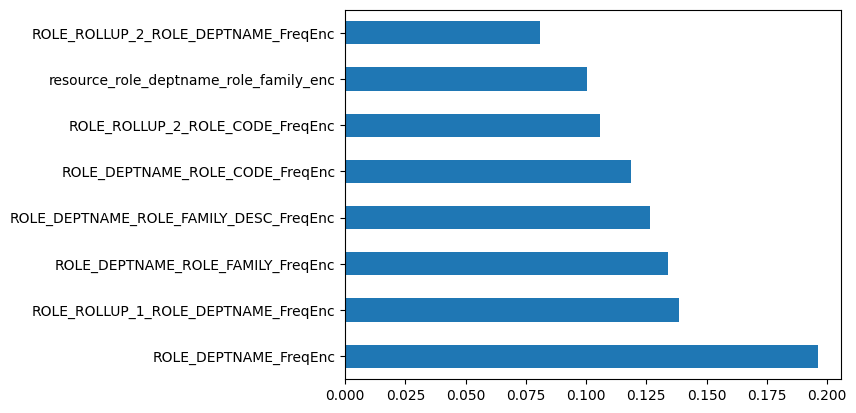

In [5]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

**Observation:**
 - ROLE_DEPTNAME_FreqEnc has is the most importance feature.

In [19]:
#train.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

In [7]:
Y_predictions_by_class

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.20930233, 0.79069767],
       ...,
       [0.04545455, 0.95454545],
       [0.06153846, 0.93846154],
       [0.03125   , 0.96875   ]])

In [10]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)

Text(0.5, 0, 'ROC-AUC: 0.901')

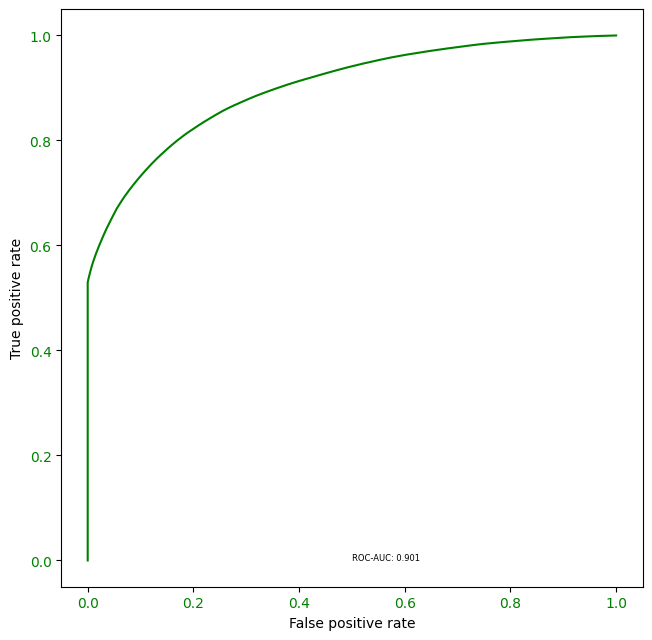

In [12]:
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [ ]:
"""
pr, rc, thresholds = precision_recall_curve(Y,  Y_predictions_by_class[:,1])
pr_auc_score = average_precision_score(Y,  Y_predictions_by_class[:,1])

pr_rc_curve_df = pd.DataFrame()    
pr_rc_curve_df['precision'] = pr
pr_rc_curve_df['recall'] = rc
pr_rc_curve_df['thresholds'] = np.insert(thresholds, len(thresholds), np.nan)

fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(pr_rc_curve_df['recall'], pr_rc_curve_df['precision'], color = 'red', label = 'Precision - Recall Curve') #, marker = '-'

ax.tick_params(axis = 'both', labelcolor = 'red')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

label_str = str.format('PR-RC-AUC: {0}',  round(pr_auc_score, 3))
ax.text(0.5, 1, label_str, fontsize = 6)

plt.show()
"""

In [13]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)
Y_pred

Best Threshold=0.934426, G-Mean=0.816


array([1, 1, 0, ..., 1, 1, 1])

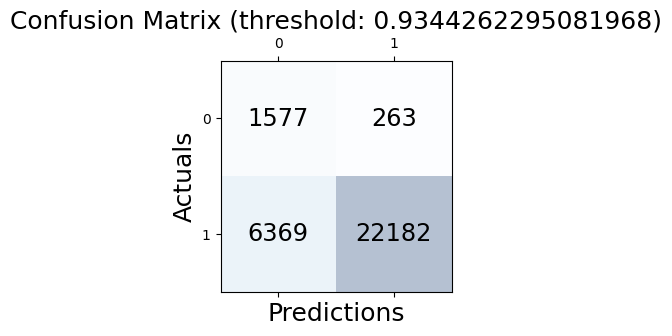

In [14]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [16]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.816995359562522 when threshold 0.9344262295081968
Classification report with threshold 0.9344262295081968
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.78      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.60     30391
weighted avg       0.94      0.78      0.84     30391



**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.71</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75</td>
</tr>
</table>

This can be our baseline model

### Trial 2 ###
 
**Paramaters**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_ROLLUP_1_ROLE_FAMILY


**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.789</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.73</td>
</tr>
</table>

In [3]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

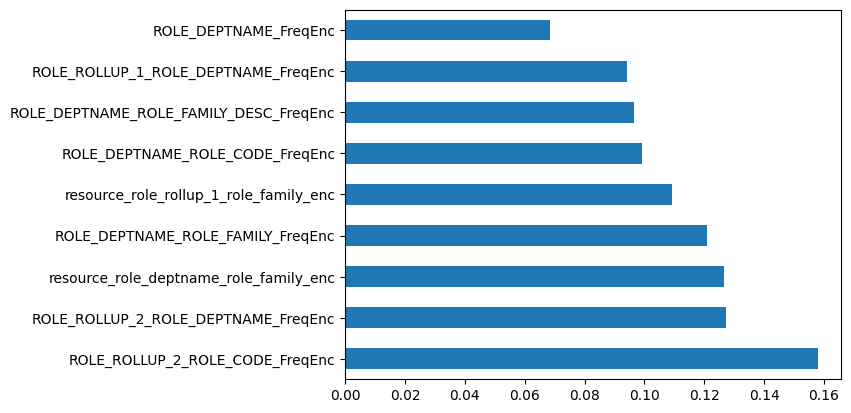

In [4]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

In [5]:
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

Text(0.5, 0, 'ROC-AUC: 0.902')

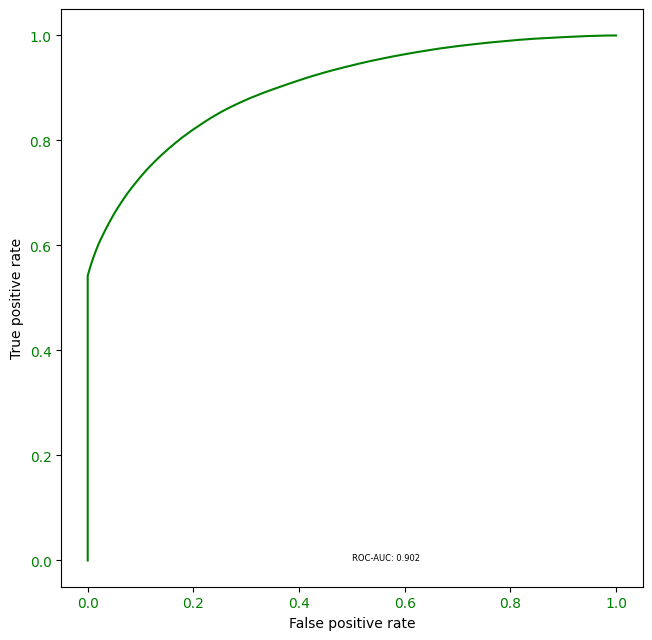

In [6]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [7]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

Best Threshold = 0.934783, G-Mean = 0.815


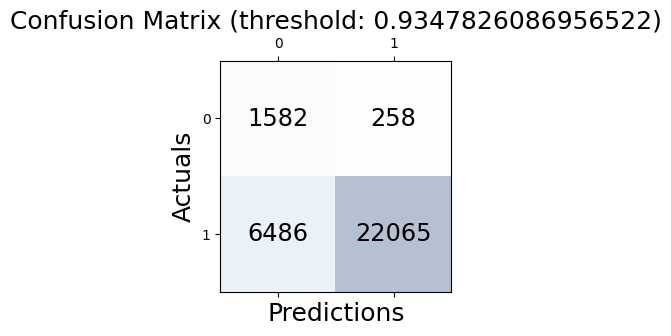

In [8]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [10]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.8163050902047138 when threshold 0.9347826086956522
Classification report with threshold 0.9347826086956522
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.77      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.59     30391
weighted avg       0.94      0.78      0.83     30391



**Output:**


<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.789</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.73</td>
</tr>
</table>

***Observation***

- We do not see much improvement in the roc in train dataset. 
- Mean roc on train is improved.
- Score on test dataset decrease. Means we overfit on train dataset.

### Trial 3 Post Pruning Decision Tree  ###

We trained the tree to full depth and then apply post pruning to find the right alpha and depth for the model.

**Paramaters**
- random_state: 1907
- splitter: best
- max_depth: 21
- ccp_alpha: 2.4e-05

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY


- Trail 1 was underfitting on train, but perfrom better then test.
- Trail 2 was overfitting on train, and underfitting on test.

**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.796</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75481</td>
</tr>
</table>

For this trial in first ran python generate_training_features.py first to generate 'train_data.parquet' output file that store the feature file and we shall use that for training. Will load that feature file.

In [3]:
train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

print(train.columns)
train.head()

Index(['ACTION', 'ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_CODE_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc', 'ROLE_DEPTNAME_ROLE_CODE_FreqEnc',
       'resource_role_deptname_role_family_enc'],
      dtype='object')


,ACTION,ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_CODE_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc,ROLE_DEPTNAME_ROLE_CODE_FreqEnc,resource_role_deptname_role_family_enc
0,1,1.845098,1.806180,1.806180,2.607455,1.724276,1.778151,1.301030,46
1,1,2.190332,2.082785,2.075547,1.278754,0.698970,1.579784,0.698970,37
2,1,2.598791,1.113943,1.113943,1.643453,0.301030,2.385606,2.130334,136
3,1,2.269513,2.240549,2.209515,2.818885,1.763428,2.181844,1.995635,109
4,1,1.643453,1.342423,1.255273,0.903090,0.778151,0.778151,0.778151,5


In [4]:
y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)

X = train

#### Find right alpha ####

In [5]:
from sklearn.model_selection import train_test_split

split_params = hlpread.read_yaml_key('train_test_split')
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = split_params['test_size'], random_state = split_params['random_seed'])

In [6]:
from sklearn.tree import DecisionTreeClassifier

#model_param = hlpread.read_yaml_key('model')
#hyper_paramater = model_param['decision_tree']['hyper_params']
#clf = DecisionTreeClassifier()
#clf.set_params(**hyper_paramater)
clf = DecisionTreeClassifier(random_state = 1907)
path = clf.cost_complexity_pruning_path(X_train, Y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.41073626e-09 3.86027250e-09 1.79416714e-08 2.22320710e-08
 2.42329068e-08 2.63785287e-08 2.86435887e-08 2.87765768e-08
 2.87765768e-08 3.77692570e-08 3.94220017e-08 4.49299187e-08
 4.65503448e-08 5.03590094e-08 5.43087356e-08 5.56682882e-08
 6.71453458e-08 7.10191158e-08 7.38598804e-08 7.51967108e-08
 7.77018029e-08 7.91355862e-08 8.75808859e-08 8.79284291e-08
 8.79284291e-08 1.09760813e-07 1.10928481e-07 1.21747056e-07
 1.21747056e-07 1.21747056e-07 1.21747056e-07 1.22796599e-07
 1.23960638e-07 1.28451966e-07 1.34290692e-07 1.47884076e-07
 1.58271172e-07 1.590284

In [8]:
len(ccp_alphas)

851

In [7]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)


#We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

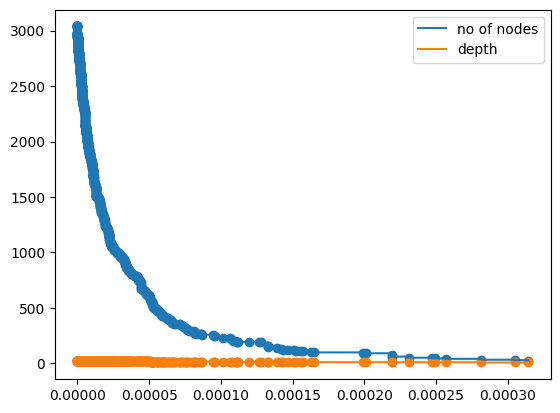

In [8]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)

plt.plot(ccp_alphas, node_counts, label = 'no of nodes',drawstyle = "steps-post")
plt.plot(ccp_alphas, depth, label = 'depth',drawstyle = "steps-post")

plt.legend()
plt.show()

**Observation**

- As alpha increase number of nodes decrease but seems depth does not change much.

Let's plot depth 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


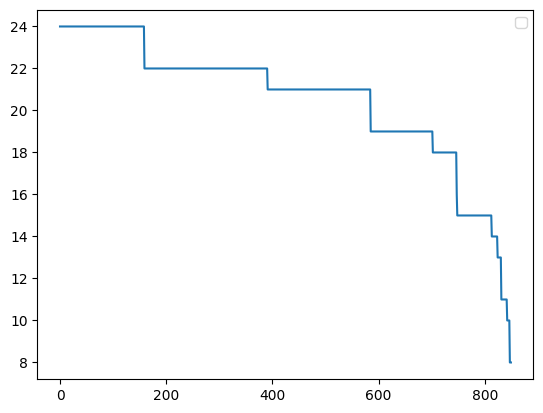

In [9]:
plt.plot(depth)
#plt.set_ylabel('depth')
plt.legend()
plt.show()

**Observation**

- Depth range from 24 to 8
- Depth remain constant for most of the case.

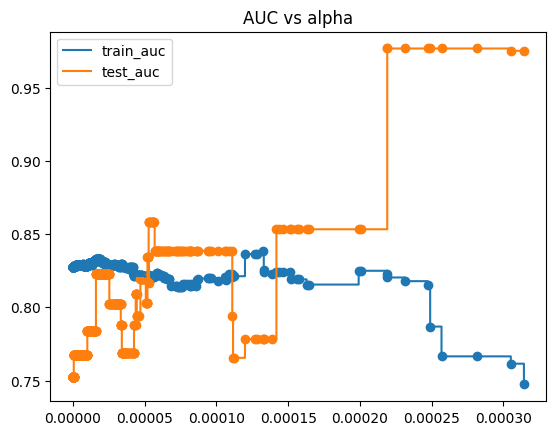

In [10]:
train_auc = []
test_auc = []

for c in clfs:
    
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)

    train_auc.append(roc_auc_score(y_train_pred, Y_train))
    test_auc.append(roc_auc_score(y_test_pred, Y_test))

plt.scatter(ccp_alphas,train_auc)
plt.scatter(ccp_alphas,test_auc)

plt.plot(ccp_alphas, train_auc, label = 'train_auc', drawstyle = "steps-post")
plt.plot(ccp_alphas, test_auc, label = 'test_auc', drawstyle = "steps-post")
plt.legend()
plt.title('AUC vs alpha')
plt.show()

**Observation**

 - Plot look crowded
 - Initial alphas where score of train and test are much close to each other. 

 Let's zoom out values of alphas that works for both train and test and then visualization those points on plot.

In [11]:
#Return the index where test score is more the 0.82. We shall use those index on train and get the equivelemnt score in train dataset.
test_np = np.array(test_auc)
index = np.where(test_np > 0.82)

print(f'Index in test where auc > 0.82: {index}')
print(f'AUC score in the test: {list(map(test_auc.__getitem__, index[0]))}')

Index in test where auc > 0.82: (array([545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557,
       558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
       584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
       597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609,
       610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622,
       623, 624, 625, 626, 627, 628, 629, 630, 631, 752, 753, 754, 755,
       756, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769,
       770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782,
       783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795,
       796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808,
       809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 830, 831,
       832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844,
       845, 846, 847, 848, 849]

In [12]:
print(f'AUC score in the train: {list(map(train_auc.__getitem__, index[0]))}')

AUC score in the train: [0.8324015728740475, 0.8326795155108776, 0.8326795155108776, 0.8328192239976098, 0.8328192239976098, 0.8329594270180918, 0.8329594270180918, 0.8329594270180918, 0.8331001269067903, 0.8329642054714568, 0.8331053422271949, 0.8331053422271949, 0.8331053422271949, 0.8329691705429602, 0.8331107465129932, 0.8331107465129932, 0.8331107465129932, 0.8332588655642283, 0.8331221272040672, 0.8331221272040672, 0.8331221272040672, 0.8331221272040672, 0.8331221272040672, 0.833271526338532, 0.8331342795524793, 0.8331342795524793, 0.8331342795524793, 0.8331342795524793, 0.8328535476798246, 0.8328535476798246, 0.8328535476798246, 0.8328535476798246, 0.8328535476798246, 0.8327159802110362, 0.8327159802110362, 0.8320106695926069, 0.8311772492357057, 0.8311772492357057, 0.8311772492357057, 0.8311785389448593, 0.8317409789200688, 0.8317409789200688, 0.8311799998203684, 0.8311799998203684, 0.8310414120747651, 0.8309026304197531, 0.8309026304197531, 0.8307636543862879, 0.83062506152333

In [13]:
train_np = np.array(train_auc)
train_index = np.where(train_np > 0.82)

print(f'Index in train where auc > 0.82: {train_index}')
print(f'AUC score in the train: {list(map(train_auc.__getitem__, index[0]))}')

Index in train where auc > 0.82: (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173

In [14]:
#Index which are similar for both train and test
intersect_index = list(set(index[0]).intersection(train_index[0]))
len(intersect_index)

131

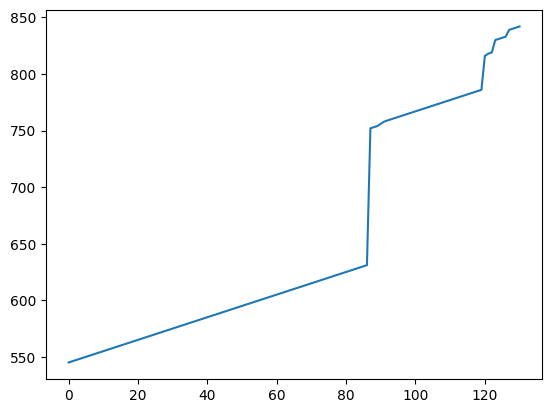

In [15]:
plt.plot(intersect_index)
plt.show()

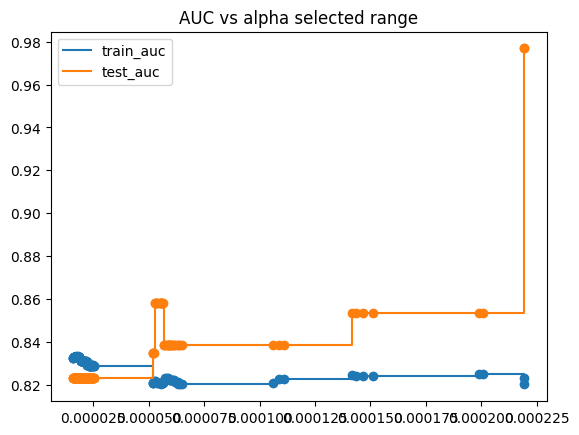

In [16]:
sub_set_train_auc = []
sub_set_test_auc = []

#alpha_start = 208
#alpha_end = 214

#for c in clfs[alpha_start : alpha_end]:
for i in intersect_index:

    c = clfs[i]    
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)

    sub_set_train_auc.append(roc_auc_score(y_train_pred, Y_train))
    sub_set_test_auc.append(roc_auc_score(y_test_pred, Y_test))

selected_ccp_alphas = np.take(ccp_alphas, intersect_index)
plt.scatter(selected_ccp_alphas, sub_set_train_auc)
plt.scatter(selected_ccp_alphas, sub_set_test_auc)
plt.plot(selected_ccp_alphas, sub_set_train_auc, label = 'train_auc', drawstyle = "steps-post")
plt.plot(selected_ccp_alphas, sub_set_test_auc, label = 'test_auc', drawstyle = "steps-post")

#plt.scatter(ccp_alphas[alpha_start : alpha_end], sub_set_train_auc)
#plt.scatter(ccp_alphas[alpha_start : alpha_end], sub_set_test_auc)
#plt.plot(ccp_alphas[alpha_start : alpha_end], sub_set_train_auc, label = 'train_auc', drawstyle = "steps-post")
#plt.plot(ccp_alphas[alpha_start : alpha_end], sub_set_test_auc, label = 'test_auc', drawstyle = "steps-post")

plt.legend()
#plt.title(f'AUC vs alpha range [{alpha_start}, {alpha_end}]')
plt.title(f'AUC vs alpha selected range')
plt.show()

In [17]:
selected_depth = np.take(depth, intersect_index)

In [18]:
sub_set_train_auc[:10]

[0.8324015728740475,
 0.8326795155108776,
 0.8326795155108776,
 0.8328192239976098,
 0.8328192239976098,
 0.8329594270180918,
 0.8329594270180918,
 0.8329594270180918,
 0.8331001269067903,
 0.8329642054714568]

In [19]:
sub_set_test_auc[:10]

[0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632,
 0.8229527104959632]

In [20]:
selected_ccp_alphas[:10]

array([1.59793011e-05, 1.60662475e-05, 1.61056864e-05, 1.63078474e-05,
       1.64840919e-05, 1.64864564e-05, 1.64915575e-05, 1.64991610e-05,
       1.65084170e-05, 1.65607701e-05])

**Observation**

- alpha of 1.59793011e-05 gave good score in both train and test data set. But we need alpha that works with entire dataset.

Lets test theses value with Cross validation and find the right alpha and depth that works for both train and different test.

#### Grid Search with CV ####

We have 131 unique alpha value, out of which most of them are change in the decimal points. to reduce the computation lets consider the unique alpha only.

In [21]:
unique_depth = []

rounded_selected_ccp_alphas = np.unique(selected_ccp_alphas.round(decimals = 6))

for i in rounded_selected_ccp_alphas:
    #print(np.where(selected_ccp_alphas.round(decimals = 6) <= i)[0][-1])
    unique_depth.append(selected_depth[np.where(selected_ccp_alphas.round(decimals = 6) <= i)[0][-1]])

#unique_depth

In [24]:
hyper_param_tune = {    
                    #'random_state': [1907]*len(selected_depth) ,              
                    'max_depth': unique_depth, #list(selected_depth),
                    'ccp_alpha': list(rounded_selected_ccp_alphas), #list(selected_ccp_alphas),
                   }

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split_params = hlpread.read_yaml_key('train_test_split')
split_s = StratifiedShuffleSplit(n_splits = split_params['cv'], test_size = split_params['test_size'], random_state = split_params['random_seed'])

In [26]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state = 1907)
grid_search_clf = GridSearchCV(estimator = model, param_grid = hyper_param_tune, cv = split_s, scoring = 'roc_auc', return_train_score = True, verbose = 3)

In [27]:
result = grid_search_clf.fit(X,y)

Fitting 5 folds for each of 1156 candidates, totalling 5780 fits
[CV 1/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.927, test=0.734) total time=   0.1s
[CV 2/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.928, test=0.753) total time=   0.1s
[CV 3/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.930, test=0.787) total time=   0.1s
[CV 4/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.930, test=0.817) total time=   0.1s
[CV 5/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.927, test=0.792) total time=   0.1s
[CV 1/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.927, test=0.734) total time=   0.0s
[CV 2/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.928, test=0.753) total time=   0.1s
[CV 3/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.930, test=0.787) total time=   0.0s
[CV 4/5] END ccp_alpha=1.6e-05, max_depth=21;, score=(train=0.930, test=0.817) total time=   0.1s
[CV 5/5] END ccp_alpha=1.6e-05, max_depth=21;, score=

In [33]:
df = pd.DataFrame(result.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.163977,0.007181,0.004178,0.001176,0.000016,21,"{'ccp_alpha': 1.6e-05, 'max_depth': 21}",0.734071,0.752914,0.787490,...,0.776729,0.029591,146,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311,0.001301
1,0.141813,0.009268,0.004389,0.000799,0.000016,21,"{'ccp_alpha': 1.6e-05, 'max_depth': 21}",0.734071,0.752914,0.787490,...,0.776729,0.029591,146,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311,0.001301
2,0.146814,0.008486,0.003788,0.000747,0.000016,21,"{'ccp_alpha': 1.6e-05, 'max_depth': 21}",0.734071,0.752914,0.787490,...,0.776729,0.029591,146,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311,0.001301
3,0.148600,0.017405,0.004575,0.000849,0.000016,19,"{'ccp_alpha': 1.6e-05, 'max_depth': 19}",0.734071,0.750874,0.787685,...,0.776399,0.029997,149,0.927206,0.927740,0.929129,0.929556,0.926739,0.928074,0.001092
4,0.139816,0.011083,0.004791,0.001965,0.000016,19,"{'ccp_alpha': 1.6e-05, 'max_depth': 19}",0.734071,0.750874,0.787685,...,0.776399,0.029997,149,0.927206,0.927740,0.929129,0.929556,0.926739,0.928074,0.001092


In [34]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_ccp_alpha', 'param_max_depth', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [35]:
consider_col = ['param_ccp_alpha', 'param_max_depth',
                'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score',
                'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score','mean_train_score',
                ]

df[consider_col]

,param_ccp_alpha,param_max_depth,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score
0,0.000016,21,0.734071,0.752914,0.787490,0.817308,0.791861,0.776729,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311
1,0.000016,21,0.734071,0.752914,0.787490,0.817308,0.791861,0.776729,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311
2,0.000016,21,0.734071,0.752914,0.787490,0.817308,0.791861,0.776729,0.927206,0.927937,0.929938,0.929729,0.926746,0.928311
3,0.000016,19,0.734071,0.750874,0.787685,0.817502,0.791861,0.776399,0.927206,0.927740,0.929129,0.929556,0.926739,0.928074
4,0.000016,19,0.734071,0.750874,0.787685,0.817502,0.791861,0.776399,0.927206,0.927740,0.929129,0.929556,0.926739,0.928074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,0.000219,11,0.679002,0.558566,0.721154,0.738345,0.620338,0.663481,0.655794,0.656328,0.673646,0.654521,0.676940,0.663446
1152,0.000219,11,0.679002,0.558566,0.721154,0.738345,0.620338,0.663481,0.655794,0.656328,0.673646,0.654521,0.676940,0.663446
1153,0.000219,11,0.679002,0.558566,0.721154,0.738345,0.620338,0.663481,0.655794,0.656328,0.673646,0.654521,0.676940,0.663446
1154,0.000219,11,0.679002,0.558566,0.721154,0.738345,0.620338,0.663481,0.655794,0.656328,0.673646,0.654521,0.676940,0.663446


In [36]:
df.sort_values(by = ['mean_test_score'], ascending= False, inplace = True)

In [37]:
df[consider_col]

,param_ccp_alpha,param_max_depth,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score
273,0.000024,21,0.694153,0.729118,0.868104,0.919095,0.770979,0.796290,0.902242,0.901946,0.905317,0.905830,0.899865,0.903040
274,0.000024,21,0.694153,0.729118,0.868104,0.919095,0.770979,0.796290,0.902242,0.901946,0.905317,0.905830,0.899865,0.903040
272,0.000024,21,0.694153,0.729118,0.868104,0.919095,0.770979,0.796290,0.902242,0.901946,0.905317,0.905830,0.899865,0.903040
281,0.000024,19,0.694153,0.727273,0.867910,0.919289,0.770979,0.795921,0.902242,0.901829,0.904972,0.905723,0.899865,0.902926
279,0.000024,19,0.694153,0.727273,0.867910,0.919289,0.770979,0.795921,0.902242,0.901829,0.904972,0.905723,0.899865,0.902926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,0.000199,11,0.613733,0.569347,0.658994,0.729992,0.620338,0.638481,0.688675,0.683409,0.681006,0.661450,0.676940,0.678296
1082,0.000199,11,0.613733,0.569347,0.658994,0.729992,0.620338,0.638481,0.688675,0.683409,0.681006,0.661450,0.676940,0.678296
1083,0.000199,11,0.613733,0.569347,0.658994,0.729992,0.620338,0.638481,0.688675,0.683409,0.681006,0.661450,0.676940,0.678296
1085,0.000199,11,0.613733,0.569347,0.658994,0.729992,0.620338,0.638481,0.688675,0.683409,0.681006,0.661450,0.676940,0.678296


In [39]:
result.best_score_

0.7962898212898213

In [38]:
result.best_params_

{'ccp_alpha': 2.4e-05, 'max_depth': 21}

<AxesSubplot:>

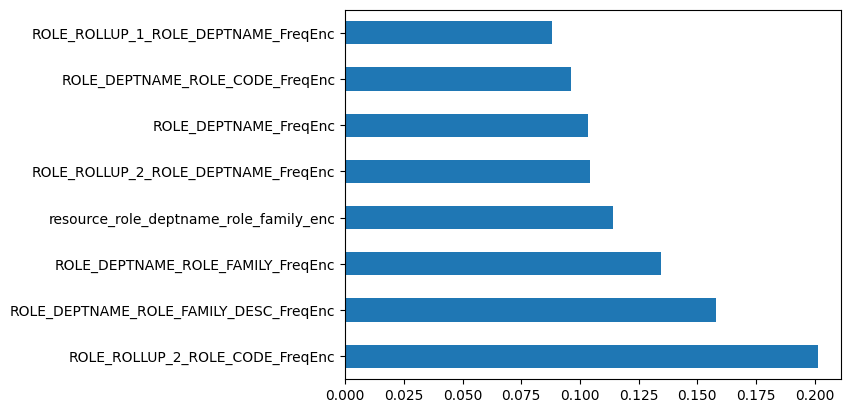

In [40]:
#predict from the best estimator
best_model = result.best_estimator_

feat_importances = pd.Series(best_model.feature_importances_, index = best_model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

**Observation**

- Most important feature is ROLE_ROLLUP_2_ROLE_CODE_FreqEnc.
- In previous experiments most important feature was ROLE_DEPTNAME_Freq_Enc. 

So added addation param alpha for train change the feature importance.

In [44]:
Y_predictions_by_class = best_model.predict_proba(X).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = y.astype(float)

Text(0.5, 0, 'ROC-AUC: 0.905')

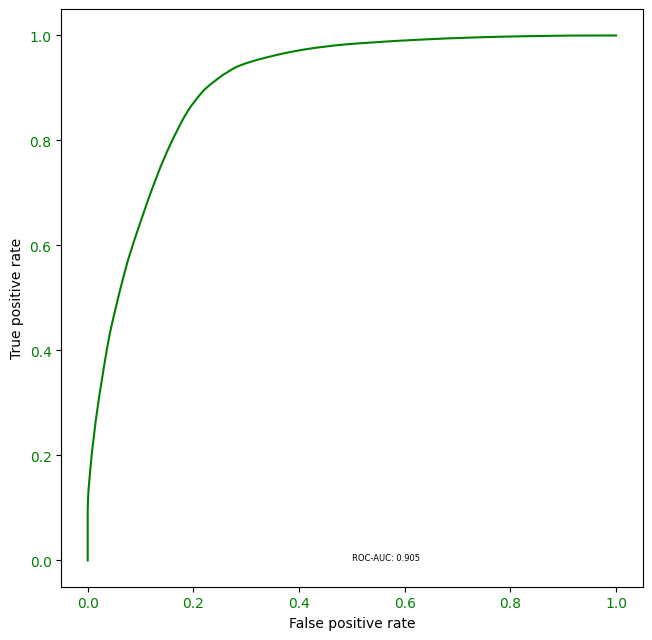

In [53]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

**Observation:**

- We get same auc score as previous trial. But in this case shape of the curve is different. We have little more curve on the left side of the plot. In previous case left side of the plot was a straight line.

In [54]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold = 0.947368, G-Mean = 0.836


In [55]:
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

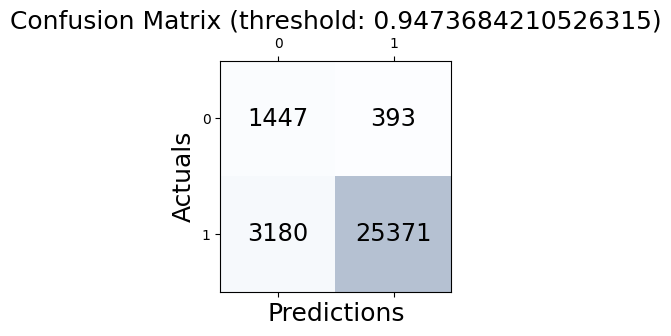

In [56]:
conf_matrix = confusion_matrix(Y, Y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [57]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.8375167035191031 when threshold 0.9473684210526315
Classification report with threshold 0.9473684210526315
              precision    recall  f1-score   support

           0       0.31      0.79      0.45      1840
           1       0.98      0.89      0.93     28551

    accuracy                           0.88     30391
   macro avg       0.65      0.84      0.69     30391
weighted avg       0.94      0.88      0.90     30391



**Observation:**

- Compare the result with Trial 1 we see good improvement in F1-Score of 0 and 1 label.
- Not much improvement in auc score.

If we see auc score does not accurately show the model performance compare to F1-score amd confusion matrix.

Let's test these on the test dataset.

**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.796</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75481</td>
</tr>
</table>


There is a bit improvement in the score from trial 1. But we have high variance.


### Trial 4 : Bagging Ensemble technique on Decision Tree ###

**Paramaters**
- base_estimator:
    * random_state: 1907
    * max_depth: 21
    * splitter: best
    * ccp_alpha: 2.4e-05
- bagging:
    * n_estimators: 19
    * test_size: 0.01
    * random_seed: 1907 

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY


**Output:**
<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.833</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.956</td>
    <td>0.78746</td>
</tr>
</table>

In [101]:
#We start our training on the feature file that was generated

train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

print(train.columns)
train.head()

Index(['ACTION', 'ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_CODE_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc', 'ROLE_DEPTNAME_ROLE_CODE_FreqEnc',
       'resource_role_deptname_role_family_enc'],
      dtype='object')


,ACTION,ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_CODE_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc,ROLE_DEPTNAME_ROLE_CODE_FreqEnc,resource_role_deptname_role_family_enc
0,1,1.845098,1.806180,1.806180,2.607455,1.724276,1.778151,1.301030,46
1,1,2.190332,2.082785,2.075547,1.278754,0.698970,1.579784,0.698970,37
2,1,2.598791,1.113943,1.113943,1.643453,0.301030,2.385606,2.130334,136
3,1,2.269513,2.240549,2.209515,2.818885,1.763428,2.181844,1.995635,109
4,1,1.643453,1.342423,1.255273,0.903090,0.778151,0.778151,0.778151,5


In [102]:
y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)

X = train

In [116]:
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(random_state = 1907, max_depth = 21, splitter = 'best', ccp_alpha = 2.4e-05)
#split_params = hlpread.read_yaml_key('train_test_split')

bagg_model = BaggingClassifier(estimator = base_estimator,
                               n_estimators = 19, #split_params['cv'], #Lets keep the it same as we have define for cv
                               max_samples = (1.0 - 0.01), #split_params['test_size'], 
                               bootstrap = True,
                               random_state = 1907, #split_params['random_seed']
                              )

In [117]:
bagg_model.fit(X,y)

BaggingClassifier(estimator=DecisionTreeClassifier(ccp_alpha=2.4e-05,
                                                   max_depth=21,
                                                   random_state=1907),
                  max_samples=0.99, n_estimators=19, random_state=1907)

In [118]:
Y_predictions_by_class = bagg_model.predict_proba(X).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = y.astype(float)

Text(0.5, 0, 'ROC-AUC: 0.956')

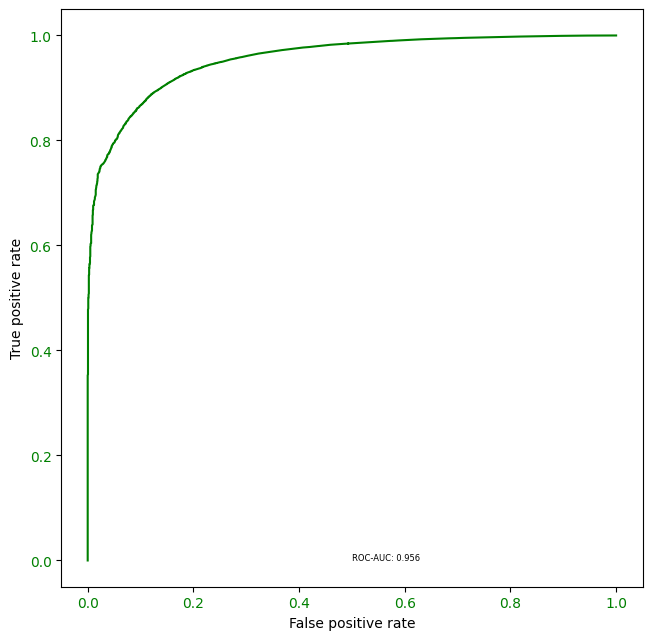

In [119]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

**Observartion:**

- Better shape of the score and improvement in roc score

In [120]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold = 0.936484, G-Mean = 0.884


In [121]:
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

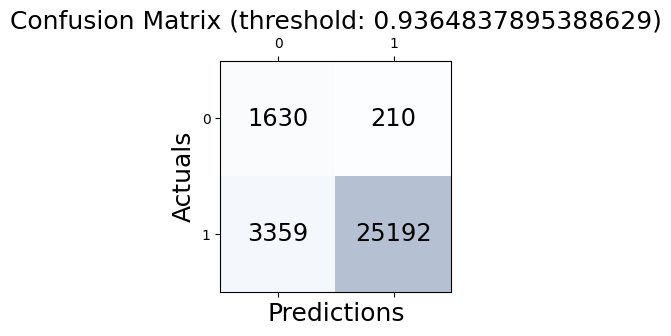

In [122]:
conf_matrix = confusion_matrix(Y, Y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize = 18)
plt.xlabel('Predictions', fontsize = 18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [123]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.8841102230486102 when threshold 0.9364837895388629
Classification report with threshold 0.9364837895388629
              precision    recall  f1-score   support

           0       0.33      0.89      0.48      1840
           1       0.99      0.88      0.93     28551

    accuracy                           0.88     30391
   macro avg       0.66      0.88      0.71     30391
weighted avg       0.95      0.88      0.91     30391



<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.833</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.956</td>
    <td>0.78746</td>
</tr>
</table>

### Trial 5 Post Pruning Decision Tree with CountVectorizer combination of feature ###

We train the model to full depth and then prune, final paramters for decision tree

**Paramaters**
* random_state: 1907
* max_depth: ?
* splitter: best
* ccp_alpha: ?

Did not find right alpha and depth. In all combination model overfitted on train dataset.

**Feature Eng Pipeline**
- count_vector: true

    *Params:*    

        - random_seed: 2023
        - targetcol: ACTION
        - combine_columns_required: false
        - concat_result_to_input: true        
        - columns: 
            - RESOURCE
            - ROLE_ROLLUP_1
            - ROLE_ROLLUP_2
            - ROLE_DEPTNAME
            - ROLE_FAMILY_DESC
            - ROLE_FAMILY
            - ROLE_CODE
        - permute_columns:
            - RESOURCE_ROLE_ROLLUP_1
            - ROLE_ROLLUP_1_ROLE_ROLLUP_2
            - ROLE_ROLLUP_1_ROLE_FAMILY_DESC
            - ROLE_ROLLUP_1_ROLE_FAMILY
            - ROLE_ROLLUP_1_ROLE_CODE
            - ROLE_FAMILY_DESC_ROLE_FAMILY
            - ROLE_FAMILY_ROLE_ROLLUP_2
            - ROLE_ROLLUP_2_ROLE_FAMILY_DESC
            - ROLE_FAMILY_DESC_ROLE_CODE

            - ROLE_ROLLUP_1_RESOURCE
            - ROLE_ROLLUP_2_ROLE_ROLLUP_1
            - ROLE_FAMILY_DESC_ROLE_ROLLUP_1
            - ROLE_FAMILY_ROLE_ROLLUP_1
            - ROLE_CODE_ROLE_ROLLUP_1
            - ROLE_FAMILY_ROLE_FAMILY_DESC
            - ROLE_ROLLUP_2_ROLE_FAMILY
            - ROLE_FAMILY_DESC_ROLE_ROLLUP_2
            - ROLE_CODE_ROLE_FAMILY_DESC

            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_DEPTNAME_ROLE_ROLLUP_1

        - dim_reduction:
            RESOURCE_ROLE_ROLLUP_1: 1
            ROLE_ROLLUP_1_ROLE_ROLLUP_2: 1
            ROLE_ROLLUP_1_ROLE_FAMILY_DESC: 1
            ROLE_ROLLUP_1_ROLE_FAMILY: 1
            ROLE_ROLLUP_1_ROLE_CODE: 1
            ROLE_FAMILY_DESC_ROLE_FAMILY: 1
            ROLE_FAMILY_ROLE_ROLLUP_2: 3
            ROLE_ROLLUP_2_ROLE_FAMILY_DESC: 4
            ROLE_FAMILY_DESC_ROLE_CODE: 5

            ROLE_ROLLUP_1_RESOURCE: 1
            ROLE_ROLLUP_2_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_DESC_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_ROLE_ROLLUP_1: 1
            ROLE_CODE_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_ROLE_FAMILY_DESC: 1
            ROLE_ROLLUP_2_ROLE_FAMILY: 3
            ROLE_FAMILY_DESC_ROLE_ROLLUP_2: 4
            ROLE_CODE_ROLE_FAMILY_DESC: 5

            ROLE_ROLLUP_1_ROLE_DEPTNAME: 5
            ROLE_DEPTNAME_ROLE_ROLLUP_1: 7


For this trial in first ran python generate_training_features.py first to generate 'train_data.parquet' output file that store the feature file and we shall use that for training. Will load that feature file.

In [3]:
#We start our training on the feature file that was generated

train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

train.drop(['resource_role_deptname_role_family_enc'], inplace = True, axis = 1)
print(train.columns)
train.head()

Index(['ACTION', 'RESOURCE_svd_ROLE_ROLLUP_1_cv',
       'ROLE_ROLLUP_1_svd_RESOURCE_cv', 'ROLE_ROLLUP_1_svd_ROLE_ROLLUP_2_cv',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_0',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_1',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_2',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_3',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_4',
       'ROLE_ROLLUP_1_svd_ROLE_FAMILY_DESC_cv',
       'ROLE_ROLLUP_1_svd_ROLE_FAMILY_cv', 'ROLE_ROLLUP_1_svd_ROLE_CODE_cv',
       'ROLE_ROLLUP_2_svd_ROLE_ROLLUP_1_cv',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_0',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_1',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_2',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_3',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_0',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_1',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_2',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_1_cv_0',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_1_cv_1',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_

,ACTION,RESOURCE_svd_ROLE_ROLLUP_1_cv,ROLE_ROLLUP_1_svd_RESOURCE_cv,ROLE_ROLLUP_1_svd_ROLE_ROLLUP_2_cv,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_0,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_1,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_2,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_3,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_4,ROLE_ROLLUP_1_svd_ROLE_FAMILY_DESC_cv,...,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_0,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_1,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_2,ROLE_FAMILY_svd_ROLE_FAMILY_DESC_cv,ROLE_CODE_svd_ROLE_ROLLUP_1_cv,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_0,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_1,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_2,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_3,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_4
0,1,2.995357,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
1,1,375.137271,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
2,1,145.218958,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
3,1,9.123025,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
4,1,7.987619,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093


In [4]:
y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)
X = train

In [5]:
from sklearn.model_selection import train_test_split

split_params = hlpread.read_yaml_key('train_test_split')
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = split_params['test_size'], random_state = split_params['random_seed'])

#### Find right alpha and depth #### 

In [6]:
from sklearn.tree import DecisionTreeClassifier

#model_param = hlpread.read_yaml_key('model')
#hyper_paramater = model_param['decision_tree']['hyper_params']
#clf = DecisionTreeClassifier()
#clf.set_params(**hyper_paramater)
clf = DecisionTreeClassifier(random_state = 1907)
path = clf.cost_complexity_pruning_path(X_train, Y_train)

In [7]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(ccp_alphas)

In [8]:
len(ccp_alphas)

1037

In [11]:
len(np.unique(ccp_alphas))

714

In [13]:
# For each alpha we will append our model to a list
ccp_alphas = np.unique(ccp_alphas)
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)

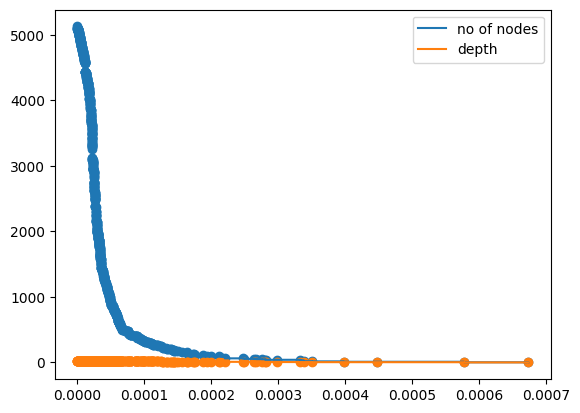

In [15]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)

plt.plot(ccp_alphas, node_counts, label = 'no of nodes',drawstyle = "steps-post")
plt.plot(ccp_alphas, depth, label = 'depth',drawstyle = "steps-post")

plt.legend()
plt.show()

**Observation**

- Initial as alpha increase number of nodes decrease.
- Depth does not change much.

Let's plot depth 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


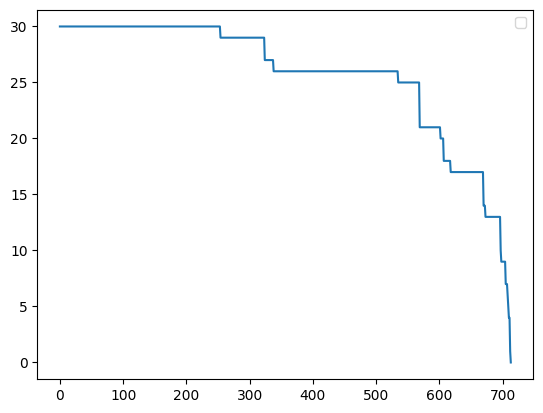

In [16]:
plt.plot(depth)
#plt.set_ylabel('depth')
plt.legend()
plt.show()

**Observation:**

- Depth range from 30 to 2
- Depth remain constant for most of the case.

In [28]:
train_auc = []
test_auc = []

for c in clfs[:-2]: #Reason used range from 0:-2 since last 2 alpha result in all 1 prediction
    
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)

    train_auc.append(roc_auc_score(y_train_pred, Y_train))
    test_auc.append(roc_auc_score(y_test_pred, Y_test))


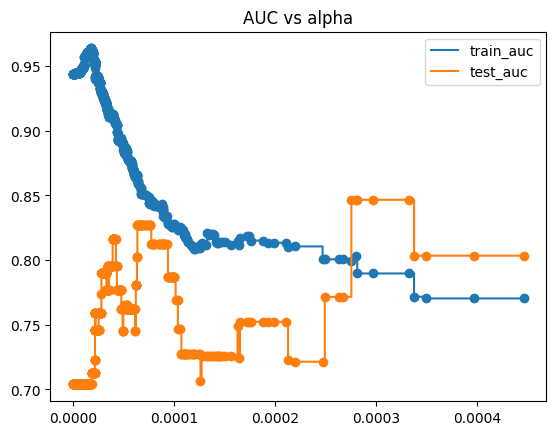

In [29]:
plt.scatter(ccp_alphas[:-2], train_auc)
plt.scatter(ccp_alphas[:-2], test_auc)

plt.plot(ccp_alphas[:-2], train_auc, label = 'train_auc', drawstyle = "steps-post")
plt.plot(ccp_alphas[:-2], test_auc, label = 'test_auc', drawstyle = "steps-post")
plt.legend()
plt.title('AUC vs alpha')
plt.show()

**Observation:**
* auc on test data differ from train dataset.

In [31]:
#Return the index where test score is more the 0.82. We shall use those index on train and get the equivelemnt score in train dataset.
test_np = np.array(test_auc)
test_index = np.where(test_np > 0.80)

print(f'Index in test where auc > 0.80: {test_index}')
print(f'AUC score in the test: {list(map(test_auc.__getitem__, test_index[0]))}')

Index in test where auc > 0.80: (array([460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
       473, 474, 475, 476, 477, 478, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601,
       602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614,
       615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627,
       628, 629, 703, 704, 705, 706, 707, 708, 709, 710, 711], dtype=int64),)
AUC score in the test: [0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8160322952710497, 0.8024630541871921, 0.8024630541871921, 0.8024630541871921, 0.8272535025112345, 0.8272535025112345, 0.8272535025112345, 0.827

In [36]:
#Let's select unique index as most of them have same auc score for test
unqiue_test_auc = [test_auc.index(i) for i in set(test_auc)]
#unqiue_test_auc

In [44]:
#Let's look at the auc on train where test has score better
print(f'AUC score in the test: \n{list(map(test_auc.__getitem__, unqiue_test_auc))}')
print("")
print(f'AUC score in the train where test gave scored:\n{list(map(train_auc.__getitem__, unqiue_test_auc))}')
print("")
print(f'Print index: {unqiue_test_auc}')
#train_np = np.array(train_auc)
#train_index = np.where(train_np > 0.80)

#print(f'Index in train where auc > 0.80: {train_index}')
#print(f'AUC score in the train: {list(map(train_auc.__getitem__, index[0]))}')

AUC score in the test: 
[0.7038709677419355, 0.7130952380952381, 0.7591549295774648, 0.7460037018340906, 0.7231161999071638, 0.7736842105263158, 0.78982128982129, 0.7766960442713671, 0.795138888888889, 0.8160322952710497, 0.7455421192867391, 0.7650246305418719, 0.7715719063545151, 0.7523540489642185, 0.780968858131488, 0.812785388127854, 0.7067142479513613, 0.7468939994713191, 0.8466666666666667, 0.7621527777777778, 0.8024630541871921, 0.7870737509912769, 0.726027397260274, 0.7488364877443374, 0.722972972972973, 0.7214765100671141, 0.8272535025112345, 0.7244897959183674, 0.7275862068965517, 0.8034330011074198, 0.7694063926940639]

AUC score in the train where test gave scored:
[0.9441161939154481, 0.9624911418673018, 0.9517099379148166, 0.9528970098410148, 0.953237849128782, 0.9295923379965804, 0.9293556882030087, 0.9201527440285923, 0.9148112123761384, 0.912654559555691, 0.8900012961485428, 0.8867751509952926, 0.8006726853372611, 0.8169825920467857, 0.8640465230298626, 0.8445796572803

In [46]:
#Index where the difference in score is not much to there alpha and depth

index = list(map(unqiue_test_auc.__getitem__, [13,16,27]))
list(map(ccp_alphas.__getitem__, index))

[0.00016540515849904, 0.00012622330771593906, 0.00016396668944607088]

In [47]:
#depth for the selected alphas
list(map(depth.__getitem__, index))

[13, 14, 13]

**Observation:**

Perform Grid search to find the optimal values
- alpha : [0.00016540515849904, 0.00012622330771593906, 0.00016396668944607088]
- depth: [13, 14, 13]

#### Grid Search with CV ####

In [3]:
train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

train.drop(['resource_role_deptname_role_family_enc'], inplace = True, axis = 1)
print(train.columns)
train.head()

Index(['ACTION', 'RESOURCE_svd_ROLE_ROLLUP_1_cv',
       'ROLE_ROLLUP_1_svd_RESOURCE_cv', 'ROLE_ROLLUP_1_svd_ROLE_ROLLUP_2_cv',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_0',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_1',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_2',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_3',
       'ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_4',
       'ROLE_ROLLUP_1_svd_ROLE_FAMILY_DESC_cv',
       'ROLE_ROLLUP_1_svd_ROLE_FAMILY_cv', 'ROLE_ROLLUP_1_svd_ROLE_CODE_cv',
       'ROLE_ROLLUP_2_svd_ROLE_ROLLUP_1_cv',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_0',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_1',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_2',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_DESC_cv_3',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_0',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_1',
       'ROLE_ROLLUP_2_svd_ROLE_FAMILY_cv_2',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_1_cv_0',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_1_cv_1',
       'ROLE_DEPTNAME_svd_ROLE_ROLLUP_

,ACTION,RESOURCE_svd_ROLE_ROLLUP_1_cv,ROLE_ROLLUP_1_svd_RESOURCE_cv,ROLE_ROLLUP_1_svd_ROLE_ROLLUP_2_cv,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_0,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_1,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_2,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_3,ROLE_ROLLUP_1_svd_ROLE_DEPTNAME_cv_4,ROLE_ROLLUP_1_svd_ROLE_FAMILY_DESC_cv,...,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_0,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_1,ROLE_FAMILY_svd_ROLE_ROLLUP_2_cv_2,ROLE_FAMILY_svd_ROLE_FAMILY_DESC_cv,ROLE_CODE_svd_ROLE_ROLLUP_1_cv,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_0,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_1,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_2,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_3,ROLE_CODE_svd_ROLE_FAMILY_DESC_cv_4
0,1,2.995357,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
1,1,375.137271,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
2,1,145.218958,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
3,1,9.123025,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093
4,1,7.987619,1109.279319,7300.212737,1804.446554,-0.260315,-2.662705,-0.161407,-2.834161,5483.461775,...,3093.966512,-201.866944,-50.86619,6213.477984,2595.536227,2346.74436,-0.640432,-0.005458,0.000325,-18.86093


In [4]:
y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)
X = train

In [5]:
hyper_param_tune = {                                  
                    'max_depth': [13, 14, 13], 
                    'ccp_alpha': [0.00016540515849904, 0.00012622330771593906, 0.00016396668944607088], 
                   }

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split_params = hlpread.read_yaml_key('train_test_split')
split_s = StratifiedShuffleSplit(n_splits = split_params['cv'], test_size = split_params['test_size'], random_state = split_params['random_seed'])

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 1907)
grid_search_clf = GridSearchCV(estimator = model, param_grid = hyper_param_tune, cv = split_s, scoring = 'roc_auc', return_train_score = True, verbose = 3)

In [9]:
result = grid_search_clf.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ccp_alpha=0.00016540515849904, max_depth=13;, score=(train=0.753, test=0.690) total time=   0.6s
[CV 2/5] END ccp_alpha=0.00016540515849904, max_depth=13;, score=(train=0.755, test=0.600) total time=   0.5s
[CV 3/5] END ccp_alpha=0.00016540515849904, max_depth=13;, score=(train=0.745, test=0.770) total time=   0.5s
[CV 4/5] END ccp_alpha=0.00016540515849904, max_depth=13;, score=(train=0.764, test=0.732) total time=   0.6s
[CV 5/5] END ccp_alpha=0.00016540515849904, max_depth=13;, score=(train=0.758, test=0.641) total time=   0.7s
[CV 1/5] END ccp_alpha=0.00016540515849904, max_depth=14;, score=(train=0.753, test=0.690) total time=   0.7s
[CV 2/5] END ccp_alpha=0.00016540515849904, max_depth=14;, score=(train=0.755, test=0.600) total time=   0.6s
[CV 3/5] END ccp_alpha=0.00016540515849904, max_depth=14;, score=(train=0.745, test=0.770) total time=   0.5s
[CV 4/5] END ccp_alpha=0.00016540515849904, max_depth=14;, s

In [10]:
df = pd.DataFrame(result.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.658435,0.065170,0.014001,0.019483,0.000165,13,"{'ccp_alpha': 0.00016540515849904, 'max_depth'...",0.690462,0.599553,0.770202,...,0.686480,0.061178,6,0.752566,0.754548,0.745344,0.764112,0.757523,0.754818,0.006142
1,0.652374,0.091074,0.004151,0.001901,0.000165,14,"{'ccp_alpha': 0.00016540515849904, 'max_depth'...",0.690268,0.599553,0.770202,...,0.685742,0.061713,9,0.752900,0.754548,0.745344,0.764112,0.757523,0.754885,0.006118
2,0.501076,0.009016,0.002681,0.000567,0.000165,13,"{'ccp_alpha': 0.00016540515849904, 'max_depth'...",0.690462,0.599553,0.770202,...,0.686480,0.061178,6,0.752566,0.754548,0.745344,0.764112,0.757523,0.754818,0.006142
3,0.587844,0.050242,0.004279,0.002000,0.000126,13,"{'ccp_alpha': 0.00012622330771593906, 'max_dep...",0.729701,0.615287,0.831682,...,0.722106,0.071953,2,0.796340,0.781492,0.781059,0.789843,0.786135,0.786974,0.005687
4,0.717057,0.154376,0.004858,0.001450,0.000126,14,"{'ccp_alpha': 0.00012622330771593906, 'max_dep...",0.704254,0.649378,0.831682,...,0.723718,0.063171,1,0.804093,0.794967,0.781059,0.790459,0.787441,0.791604,0.007709


In [17]:
df.sort_values(by = ['mean_test_score'], ascending = False, inplace = True)

In [18]:
consider_col = ['param_ccp_alpha', 'param_max_depth',
                'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score',
                'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score','mean_train_score',
                ]

df[consider_col]

,param_ccp_alpha,param_max_depth,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score
4,0.000126,14,0.704254,0.649378,0.831682,0.750486,0.682789,0.723718,0.804093,0.794967,0.781059,0.790459,0.787441,0.791604
3,0.000126,13,0.729701,0.615287,0.831682,0.751263,0.682595,0.722106,0.796340,0.781492,0.781059,0.789843,0.786135,0.786974
5,0.000126,13,0.729701,0.615287,0.831682,0.751263,0.682595,0.722106,0.796340,0.781492,0.781059,0.789843,0.786135,0.786974
6,0.000164,13,0.693570,0.599553,0.770202,0.731740,0.640637,0.687141,0.752932,0.754548,0.745344,0.764272,0.757523,0.754924
8,0.000164,13,0.693570,0.599553,0.770202,0.731740,0.640637,0.687141,0.752932,0.754548,0.745344,0.764272,0.757523,0.754924
0,0.000165,13,0.690462,0.599553,0.770202,0.731546,0.640637,0.686480,0.752566,0.754548,0.745344,0.764112,0.757523,0.754818
2,0.000165,13,0.690462,0.599553,0.770202,0.731546,0.640637,0.686480,0.752566,0.754548,0.745344,0.764112,0.757523,0.754818
7,0.000164,14,0.693376,0.599553,0.770202,0.731740,0.637141,0.686402,0.753264,0.754548,0.745344,0.764272,0.757523,0.754990
1,0.000165,14,0.690268,0.599553,0.770202,0.731546,0.637141,0.685742,0.752900,0.754548,0.745344,0.764112,0.757523,0.754885


In [19]:
df[['mean_test_score','mean_train_score']]

,mean_test_score,mean_train_score
4,0.723718,0.791604
3,0.722106,0.786974
5,0.722106,0.786974
6,0.687141,0.754924
8,0.687141,0.754924
0,0.686480,0.754818
2,0.686480,0.754818
7,0.686402,0.754990
1,0.685742,0.754885


In [14]:
#predict from the best estimator
best_model = result.best_estimator_

<AxesSubplot:>

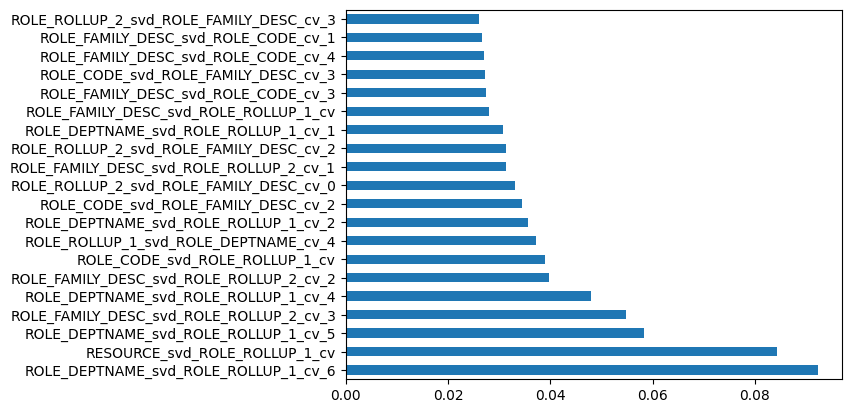

In [15]:
feat_importances = pd.Series(best_model.feature_importances_, index = best_model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

**Observation:**

- Model does not perform well in train dataset compare to the previous models

### Trial 6 : Bagging Ensemble technique on Decision Tree with CountVectorization ###

**Paramaters**
- base_estimator:
    * random_state: 1907
    * max_depth: 6
    * splitter: best
- bagging:
    * random_seed: 2444
    * n_estimators: 74
    * max_samples: 0.82
    * max_features: 0.6

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY


- count_vector: true

    *Params:*    

        - random_seed: 2023
        - targetcol: ACTION
        - combine_columns_required: false
        - concat_result_to_input: true        
        - columns: 
            - RESOURCE
            - ROLE_ROLLUP_1
            - ROLE_ROLLUP_2
            - ROLE_DEPTNAME
            - ROLE_FAMILY_DESC
            - ROLE_FAMILY
            - ROLE_CODE
        - permute_columns:
            - RESOURCE_ROLE_ROLLUP_1
            - ROLE_ROLLUP_1_ROLE_ROLLUP_2
            - ROLE_ROLLUP_1_ROLE_FAMILY_DESC
            - ROLE_ROLLUP_1_ROLE_FAMILY
            - ROLE_ROLLUP_1_ROLE_CODE
            - ROLE_FAMILY_DESC_ROLE_FAMILY
            - ROLE_FAMILY_ROLE_ROLLUP_2
            - ROLE_ROLLUP_2_ROLE_FAMILY_DESC
            - ROLE_FAMILY_DESC_ROLE_CODE

            - ROLE_ROLLUP_1_RESOURCE
            - ROLE_ROLLUP_2_ROLE_ROLLUP_1
            - ROLE_FAMILY_DESC_ROLE_ROLLUP_1
            - ROLE_FAMILY_ROLE_ROLLUP_1
            - ROLE_CODE_ROLE_ROLLUP_1
            - ROLE_FAMILY_ROLE_FAMILY_DESC
            - ROLE_ROLLUP_2_ROLE_FAMILY
            - ROLE_FAMILY_DESC_ROLE_ROLLUP_2
            - ROLE_CODE_ROLE_FAMILY_DESC

            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_DEPTNAME_ROLE_ROLLUP_1

        - dim_reduction:
            RESOURCE_ROLE_ROLLUP_1: 1
            ROLE_ROLLUP_1_ROLE_ROLLUP_2: 1
            ROLE_ROLLUP_1_ROLE_FAMILY_DESC: 1
            ROLE_ROLLUP_1_ROLE_FAMILY: 1
            ROLE_ROLLUP_1_ROLE_CODE: 1
            ROLE_FAMILY_DESC_ROLE_FAMILY: 1
            ROLE_FAMILY_ROLE_ROLLUP_2: 3
            ROLE_ROLLUP_2_ROLE_FAMILY_DESC: 4
            ROLE_FAMILY_DESC_ROLE_CODE: 5

            ROLE_ROLLUP_1_RESOURCE: 1
            ROLE_ROLLUP_2_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_DESC_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_ROLE_ROLLUP_1: 1
            ROLE_CODE_ROLE_ROLLUP_1: 1
            ROLE_FAMILY_ROLE_FAMILY_DESC: 1
            ROLE_ROLLUP_2_ROLE_FAMILY: 3
            ROLE_FAMILY_DESC_ROLE_ROLLUP_2: 4
            ROLE_CODE_ROLE_FAMILY_DESC: 5

            ROLE_ROLLUP_1_ROLE_DEPTNAME: 5
            ROLE_DEPTNAME_ROLE_ROLLUP_1: 7

**Output**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.80</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.844</td>
    <td>0.504</td>
</tr>
</table>

In [3]:
train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)
X = train

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(random_state = 1907, max_depth = 6, splitter = 'best')
bagg_model = BaggingClassifier(
                            estimator = base_estimator,
                            n_estimators = 74,
                            max_samples = 0.82,
                            max_features = 0.6,
                            bootstrap = True,
                            bootstrap_features = True,
                            random_state = 2444

)

In [6]:
bagg_model.fit(X,y)

BaggingClassifier(bootstrap_features=True,
                  estimator=DecisionTreeClassifier(max_depth=6,
                                                   random_state=1907),
                  max_features=0.6, max_samples=0.82, n_estimators=74,
                  random_state=2444)

In [9]:
Y_predictions_by_class = bagg_model.predict_proba(train).astype(float) #Return 2d numpy array which is the probaility for each class label

Text(0.5, 0, 'ROC-AUC: 0.844')

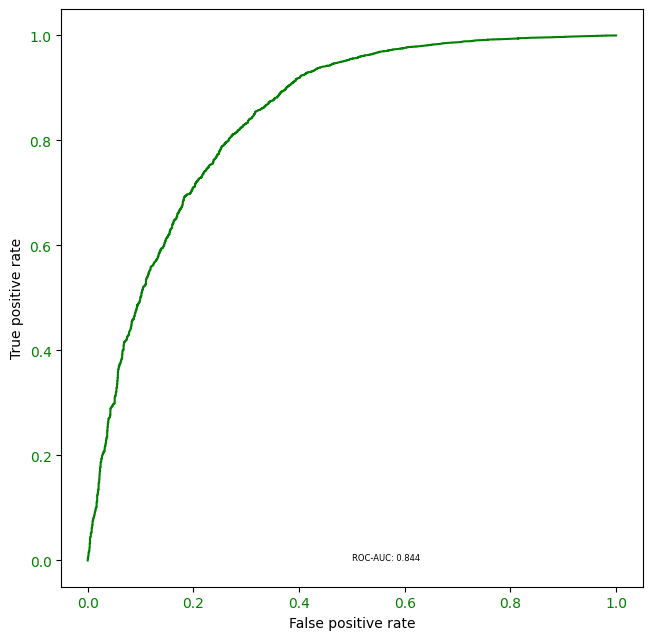

In [10]:
auc_curve = roc_auc_score(y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [11]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

threshold = thresholds[ix]
y = np.array(y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

Best Threshold = 0.926424, G-Mean = 0.767


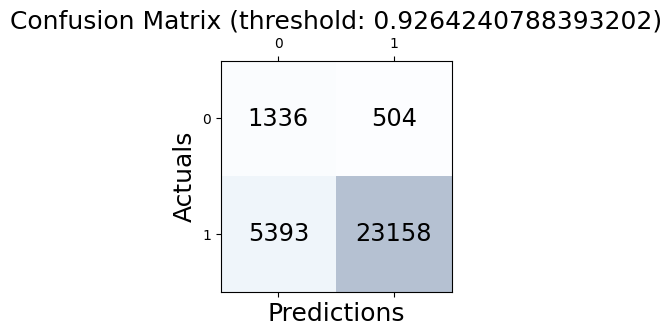

In [13]:
conf_matrix = confusion_matrix(y, Y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [14]:
print(f'Balance accuracy score: {balanced_accuracy_score(y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(y, Y_pred))

Balance accuracy score: 0.76859845006571 when threshold 0.9264240788393202
Classification report with threshold 0.9264240788393202
              precision    recall  f1-score   support

           0       0.20      0.73      0.31      1840
           1       0.98      0.81      0.89     28551

    accuracy                           0.81     30391
   macro avg       0.59      0.77      0.60     30391
weighted avg       0.93      0.81      0.85     30391



<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.80</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.844</td>
    <td>0.504</td>
</tr>
</table>


Till now trial 4 gave the best result

### Trial 7 : Feature transformations with ensembles of trees ###



**Output**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.839</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.94</td>
    <td>0.782</td>
</tr>
</table>

In [1]:
from sklearn.pipeline import Pipeline
import utils.read_utils as hlpread
import utils.paths as plh
import os

In [9]:
PROJECT_ROOT = plh.get_project_root()

clean_train_data = os.path.join(PROJECT_ROOT,
                                hlpread.read_yaml_key('data_source.data_folders'),
                                hlpread.read_yaml_key('data_source.prepared.folder'),
                                hlpread.read_yaml_key('data_source.prepared.clean_train'),
                                )
db_train = hlpread.read_from_parquet(clean_train_data)
db_train.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)

#### Generate embedding using RandomForest/GBDT. ####
Find which enbedding can be used

In [15]:
from sklearn.model_selection import train_test_split

split_params = hlpread.read_yaml_key('train_test_split')
X_train, X_test = train_test_split(db_train,  test_size = split_params['test_size'], random_state = split_params['random_seed'], shuffle = True)

Y_train = X_train['ACTION']
Y_test = X_test['ACTION']

X_train.drop('ACTION', axis = 1, inplace = True)
X_test.drop('ACTION', axis = 1, inplace = True)

In [18]:
feature_columns = X_train.select_dtypes(include = ['object']).columns
print(feature_columns)

X_train[feature_columns].head()

Index(['RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE'],
      dtype='object')


,RESOURCE,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2,ROLE_ROLLUP_1_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_FAMILY_DESC,...,ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE
29702,23994,117961,118343,118395,233714,118398,123068,117961 118343,117961 118395,117961 233714,...,118343 118395,118343 233714,118343 118398,118343 123068,118395 233714,118395 118398,118395 123068,233714 118398,233714 123068,118398 123068
1045,38989,118290,118291,118597,118294,118295,118296,118290 118291,118290 118597,118290 118294,...,118291 118597,118291 118294,118291 118295,118291 118296,118597 118294,118597 118295,118597 118296,118294 118295,118294 118296,118295 118296
8815,78563,119134,119135,123007,305850,118424,120791,119134 119135,119134 123007,119134 305850,...,119135 123007,119135 305850,119135 118424,119135 120791,123007 305850,123007 118424,123007 120791,305850 118424,305850 120791,118424 120791
8034,35683,117961,118300,118437,168365,118205,119964,117961 118300,117961 118437,117961 168365,...,118300 118437,118300 168365,118300 118205,118300 119964,118437 168365,118437 118205,118437 119964,168365 118205,168365 119964,118205 119964
11141,35524,118192,118193,117895,118195,117887,118196,118192 118193,118192 117895,118192 118195,...,118193 117895,118193 118195,118193 117887,118193 118196,117895 118195,117895 117887,117895 118196,118195 117887,118195 118196,117887 118196


In [21]:
#Since Tree based model can not handel string. Will only consider non combine feature
feature_columns = ['RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',]
n_estimators = len(feature_columns) #Let's create features for the catagory featues
max_depth = 2

Perform two experiment
1. Using RandomForest to generate features
2. Using GBDT to generate features 

Output of the feature is then inputed to logistic regression

In [34]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

random_forest = RandomForestClassifier(
                                        n_estimators = n_estimators, 
                                        max_depth = max_depth, 
                                        random_state = 10
                )
random_forest.fit(X_train[feature_columns], Y_train)


def rf_apply(X, model):

    #Apply trees in the forest to X, return leaf indices.
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args = {"model": random_forest})

rf_model = Pipeline(steps = [
                            #random_forest,
                            ('rf_leaf_indices', rf_leaves_yielder),
                            ('On_hot_encoded_leaf_index' , OneHotEncoder(handle_unknown = "ignore")),
                            ('LR_model' , LogisticRegression(max_iter = 1000))
    ])

rf_model.fit(X_train[feature_columns], Y_train)

Pipeline(steps=[('rf_leaf_indices',
                 FunctionTransformer(func=<function rf_apply at 0x000001DE302CE550>,
                                     kw_args={'model': RandomForestClassifier(max_depth=2,
                                                                              n_estimators=7,
                                                                              random_state=10)})),
                ('On_hot_encoded_leaf_index',
                 OneHotEncoder(handle_unknown='ignore')),
                ('LR_model', LogisticRegression(max_iter=1000))])

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
gradient_boosting.fit(X_train[feature_columns],Y_train)


def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args = {"model": gradient_boosting}
)

gbdt_model = Pipeline(steps = [
    ('gbdt_leaf_indices', gbdt_leaves_yielder),
    ('On_hot_encoded_leaf_index' , OneHotEncoder(handle_unknown = "ignore")),
    ('LR_model' ,LogisticRegression(max_iter = 1000)),
    ])
    
gbdt_model.fit(X_train[feature_columns], Y_train)

f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('gbdt_leaf_indices',
                 FunctionTransformer(func=<function gbdt_apply at 0x000001DE300D4550>,
                                     kw_args={'model': GradientBoostingClassifier(max_depth=2,
                                                                                  n_estimators=7,
                                                                                  random_state=10)})),
                ('On_hot_encoded_leaf_index',
                 OneHotEncoder(handle_unknown='ignore')),
                ('LR_model', LogisticRegression(max_iter=1000))])

In [35]:
models = [
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]

f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


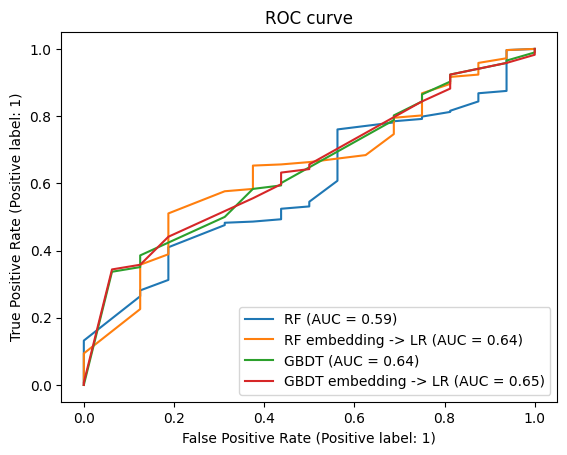

In [36]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

model_displays = {}
fig, ax = plt.subplots()

for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test[feature_columns], Y_test, ax = ax, name = name
    )
_ = ax.set_title("ROC curve")

**Observation**

1. AUC score with embedding generated by GBDT is better. It gave AUC score as 0.65. 

Let's use feature generated by GBDT -> LR with Bagging to see if there is an improvement in the AUC.

#### Train with VottingClassfication with ensemble with ####

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.ResourceEncodeByFeature import ResourceEncodeByFeature
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingClassifier


def define_model(X_train, Y_train):

    #Random Forest model
    def feature_engg_apply(X):
        
        #X.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
        feature_columns = X.select_dtypes(exclude = ['object']).columns
        return X[feature_columns]

    feature_engg = Pipeline(steps = [
                                    ('combine_feature', CombineFeatures()),
                                    ('frequency_encoding', FrequencyEncoding()), 
                                    ('encode_resource_grpby_role_deptname_role_family', ResourceEncodeByFeature()),
                                    ('remove_object_col', FunctionTransformer(feature_engg_apply))
                        ])        

    RF_model = RandomForestClassifier(n_estimators = 19, 
                                    random_state = 1907, 
                                    max_depth = 21, 
                                    #splitter = 'best', 
                                    ccp_alpha = 2.4e-05,
                                    bootstrap = True,
                                    max_features = None,#'sqrt',
                                    max_samples = 0.99,  #(1.0 - 0.01)
                                    )
    RF_pipeline = Pipeline(steps = [("preprocessor", feature_engg), ("random_forest_model",  RF_model)] )


    #GBDT Embedding based mode
    feature_columns = ['RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',]
    n_estimators = len(feature_columns) #Let's create features for the catagory featues
    max_depth = 2

    gradient_boosting = GradientBoostingClassifier(
                                                    n_estimators = n_estimators, 
                                                    max_depth = max_depth, 
                                                    random_state = 10
    )
    gradient_boosting.fit(X_train[feature_columns], Y_train)


    def gbdt_apply(X, model):
        return model.apply(X)[:, :, 0]


    gbdt_leaves_yielder = FunctionTransformer(
        gbdt_apply, kw_args = {"model": gradient_boosting}
    )

    gbdt_pipeline = Pipeline(steps = [
        ('gbdt_leaf_indices', gbdt_leaves_yielder),
        ('On_hot_encoded_leaf_index' , OneHotEncoder(handle_unknown = "ignore")),
        ('LR_model' ,LogisticRegression(max_iter = 1000)),
        ])



    #Final Stacking Classifier model
    estimators = [
              ('rf', RF_pipeline),
              ('gbdt', gbdt_pipeline)
             ]

    model = StackingClassifier(
                                estimators = estimators, 
                                final_estimator = LogisticRegression(),
                                cv = split_params['cv'],
                                stack_method = 'predict_proba',
                            )

    return model

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

cv_roc = {}
cv_f1_score = {}

split_params = hlpread.read_yaml_key('train_test_split')
split_s = StratifiedShuffleSplit(n_splits = split_params['cv'], test_size = split_params['test_size'], random_state = split_params['random_seed'])

fold = 0
for train_index, test_index in split_s.split(db_train, db_train.ACTION):
        
    X_train, X_test = db_train.iloc[train_index,:], db_train.iloc[test_index,:]

    Y_train = X_train.ACTION
    Y_test = X_test.ACTION
    
    X_train.drop('ACTION', axis = 1, inplace = True)
    X_test.drop('ACTION', axis = 1, inplace = True)

    model = define_model(X_train, Y_train)
    model.fit(X_train, Y_train) 

    Y_test_pred = model.predict_proba(X_test).astype(float)
    auc_score = roc_auc_score(Y_test.astype(float), Y_test_pred[:,1])
    cv_roc[fold] = auc_score
    
    cv_f1_score[fold] = f1_score(Y_test.astype(float), Y_test_pred.argmax(-1))    
    fold += 1

f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_

In [21]:
metrics = {
        'roc_auc': sum(cv_roc.values()) / len(cv_roc),
        'f1_score': sum(cv_f1_score.values()) / len(cv_f1_score),
    }

metrics

{'roc_auc': 0.8398018648018647, 'f1_score': 0.9732687731987479}

##### Train with entire dataset #####

In [22]:
y = db_train.ACTION
X = db_train.drop('ACTION', axis = 1)

model = define_model(X, y)
model.fit(X, y) 

f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor 

StackingClassifier(cv=5,
                   estimators=[('rf',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('combine_feature',
                                                                  CombineFeatures()),
                                                                 ('frequency_encoding',
                                                                  FrequencyEncoding()),
                                                                 ('encode_resource_grpby_role_deptname_role_family',
                                                                  ResourceEncodeByFeature()),
                                                                 ('remove_object_col',
                                                                  FunctionTransformer(func=<function define_model.<locals>.feature_engg_apply at 0x00...
                                                 FunctionTransformer(func=<function define_model.<locals>.gbdt_apply at 0x000001F393BB0AF0>,
                                                                     kw_args={'model': GradientBoostingClassifier(max_depth=2,
                                                                                                                  n_estimators=7,
                                                                                                                  random_state=10)})),
                                                ('On_hot_encoded_leaf_index',
                                                 OneHotEncoder(handle_unknown='ignore')),
                                                ('LR_model',
                                                 LogisticRegression(max_iter=1000))]))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [27]:
Y_predictions_by_class = model.predict_proba(X).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = y

f:\github_workspace\employee_access_resource_classifier\.env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Text(0.5, 0, 'ROC-AUC: 0.946')

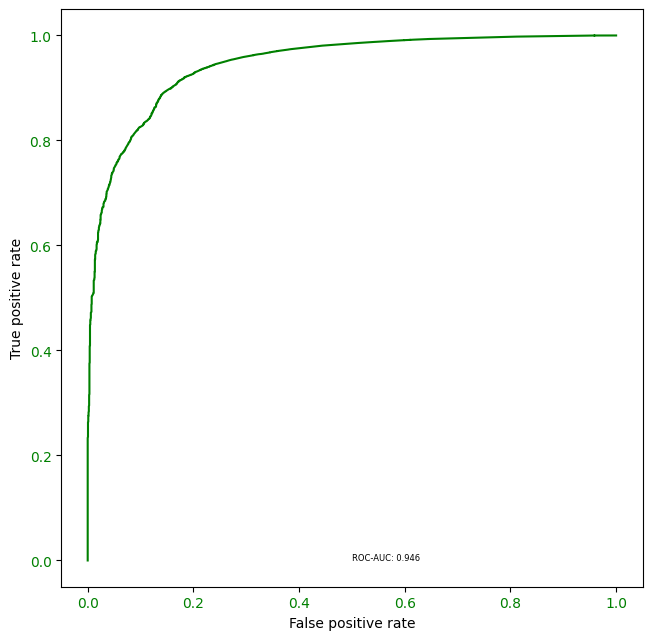

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd


auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [34]:
import numpy as np

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold = 0.955222, G-Mean = 0.874


In [35]:
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

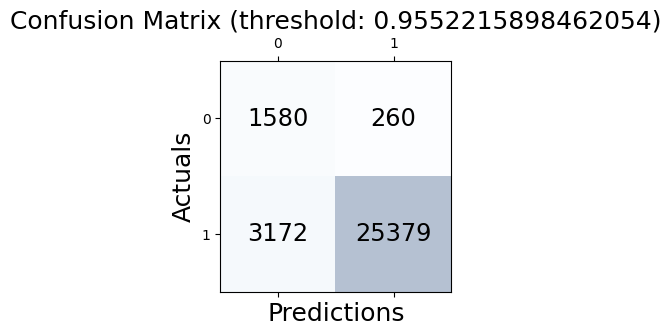

In [37]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y, Y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [39]:
from sklearn.metrics import balanced_accuracy_score
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

Balance accuracy score: 0.873798108038552 when threshold 0.9552215898462054


In [38]:
from sklearn.metrics import classification_report

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Classification report with threshold 0.9552215898462054
              precision    recall  f1-score   support

           0       0.33      0.86      0.48      1840
           1       0.99      0.89      0.94     28551

    accuracy                           0.89     30391
   macro avg       0.66      0.87      0.71     30391
weighted avg       0.95      0.89      0.91     30391




**Output**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.839</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.94</td>
    <td>0.782</td>
</tr>
</table>

## Commented code ##

In [ ]:
"""
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')


Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)


auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)


# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)


conf_matrix = confusion_matrix(Y, Y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()


print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))
"""